In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35721 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:40563 Dashboard: http://127.0.0.1:35721/status,Cluster Workers: 4 Cores: 4 Memory: 44.92 GiB


In [3]:
temp_ds = xr.open_dataset('/g/data/w40/rl5183/20CR/temp/monthly_TXx_all_members_1x1.nc', chunks={'member':1, 'time':-1, 'lat':110, 'lon':110})
temp_data = temp_ds.TMP2m
temp_data
# Detrend temp data
temp_data_dt = temp_data.groupby('time.month').map(func.detrend_by_month_ufunc).chunk(chunks={'member':1, 'time':-1, 'lat':110, 'lon':110})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

In [4]:
temp_data_dt

,Array,Chunk
Bytes,76.94 GiB,183.89 MiB
Shape,"(80, 1992, 180, 360)","(1, 1992, 110, 110)"
Count,1329921 Tasks,640 Chunks
Type,float64,numpy.ndarray


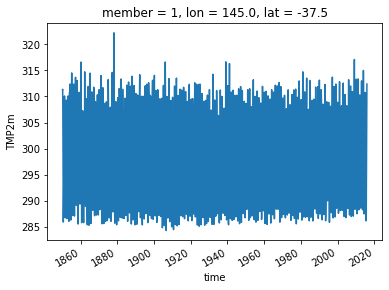

In [6]:
# check detrending worked 
temp_data.sel(member=1).sel(lon=144.9, lat=-37.38, method='nearest').plot()

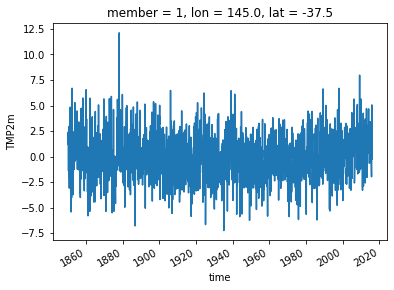

In [7]:
temp_data_dt.sel(member=1).sel(lon=144.9, lat=-37.38, method='nearest').plot()

In [8]:
# Save progress to file
climtas.io.to_netcdf_throttled(temp_data_dt, '/g/data/w40/rl5183/progress_files/TXx_detrended.nc')

  0%|          | 0/640 [00:00<?, ?it/s]

In [4]:
temp_data_dt = xr.open_dataarray('/g/data/w40/rl5183/progress_files/TXx_detrended.nc', chunks={'member':1, 'time':-1, 'lat':110, 'lon':110}).sel(time=slice('1901-11', '2015-10'))

In [10]:
temp_data_dt

,Array,Chunk
Bytes,52.84 GiB,126.29 MiB
Shape,"(80, 1368, 180, 360)","(1, 1368, 110, 110)"
Count,1281 Tasks,640 Chunks
Type,float64,numpy.ndarray


### Open HadISST dataset

In [5]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [6]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [7]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-11', '2015-10'))/sst_std

In [8]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [9]:
def ensemble_regression(data, nino):
    
    # Take max over every quarter 
    quarterly_data = data.resample(time='QS-NOV').max('time')

    # Calculate instantaneous regression 
    quarterly_regression = func.regress_nino_by_month(quarterly_data, nino)
    
    return quarterly_regression 

In [10]:
%%time 
regression_list = []
for m in temp_data_dt.member:
    regression_list.append(ensemble_regression(temp_data_dt.sel(member=m), nino_ndj))

CPU times: user 4h 28min 1s, sys: 31min 53s, total: 4h 59min 54s
Wall time: 5h 20min 54s


In [11]:
regressions = xr.concat(regression_list, dim='member')

In [12]:
regressions 

<xarray.DataArray (member: 80, month: 4, lat: 180, lon: 360)>
array([[[[ 5.36515734e-01,  5.41747000e-01,  5.39774884e-01, ...,
           5.46564787e-01,  5.41681422e-01,  5.36203864e-01],
         [ 4.62496762e-01,  4.61210814e-01,  4.60179585e-01, ...,
           4.61679706e-01,  4.60353320e-01,  4.58675394e-01],
         [ 4.66527403e-01,  4.63014910e-01,  4.59880528e-01, ...,
           4.72160402e-01,  4.66085392e-01,  4.68718213e-01],
         ...,
         [-2.05790066e-01, -2.23126753e-01, -2.41881838e-01, ...,
          -1.37006735e-01, -1.64998756e-01, -1.88839973e-01],
         [-1.77229294e-01, -1.94126106e-01, -2.10822700e-01, ...,
          -1.24822693e-01, -1.43012723e-01, -1.61062278e-01],
         [-5.76762515e-02, -6.44839751e-02, -6.55325818e-02, ...,
          -4.63911845e-02, -5.12125654e-02, -5.38187151e-02]],

        [[ 5.94848368e-01,  6.08295149e-01,  6.11988669e-01, ...,
           5.78300459e-01,  5.83111294e-01,  5.90724651e-01],
         [ 7.30367034e-01,  7.38039040e-01,  7.51167200e-01, ...,
           6.95449281e-01,  7.06532704e-01,  7.17806145e-01],
         [ 6.61032480e-01,  6.66221340e-01,  6.89460707e-01, ...,
           6.54517842e-01,  6.53866125e-01,  6.59456337e-01],
...
         [-2.29206904e-01, -2.28585041e-01, -2.27770772e-01, ...,
          -2.10319058e-01, -2.17970765e-01, -2.22666522e-01],
         [-3.16574311e-01, -3.21318154e-01, -3.26958448e-01, ...,
          -2.92001202e-01, -2.99340051e-01, -3.06953134e-01],
         [-3.31029033e-01, -3.30461742e-01, -3.34456365e-01, ...,
          -3.28524955e-01, -3.29761277e-01, -3.31122935e-01]],

        [[-6.92704251e-01, -6.96357839e-01, -7.01038237e-01, ...,
          -6.81675856e-01, -6.85051374e-01, -6.86826270e-01],
         [-7.97517789e-01, -7.97979463e-01, -8.01055237e-01, ...,
          -7.80356446e-01, -7.85414680e-01, -7.91554525e-01],
         [-7.27046399e-01, -7.27085267e-01, -7.30317456e-01, ...,
          -7.03895955e-01, -7.12327586e-01, -7.23116611e-01],
         ...,
         [ 6.33648165e-01,  6.54210613e-01,  6.74408995e-01, ...,
           5.58739869e-01,  5.87526860e-01,  6.08260415e-01],
         [ 5.09216221e-01,  5.15188862e-01,  5.21460725e-01, ...,
           4.83755690e-01,  4.91626991e-01,  5.02215151e-01],
         [ 3.13056701e-01,  3.12217547e-01,  3.14617447e-01, ...,
           3.07826976e-01,  3.09073638e-01,  3.13564761e-01]]]])
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 2 5 8 11

In [13]:
# Save as netcdf
regressions.to_netcdf('/g/data/w40/rl5183/20CR/temp/TXx_regressions_all_members_1901_2015.nc')

In [2]:
regressions = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/TXx_regressions_all_members_1901_2015.nc')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-5-c2dfc4845bec>:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('20CR_ensemble_regression_TXx_NDJ.pdf', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-5-c2dfc4845bec>:22: MatplotlibDeprecationWarning: savefig() go

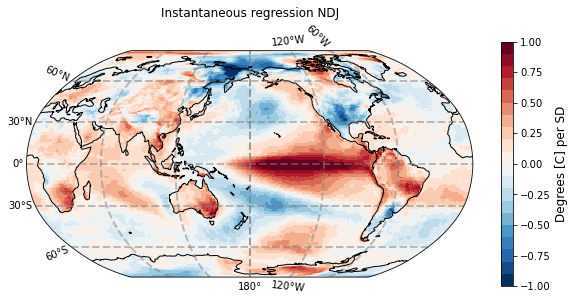

In [5]:
# Plot ensemble mean to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = regressions.sel(month=11).mean(dim='member').plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Degrees [C] per SD', fontsize=12)

# Save figure as pdf
# plt.savefig('20CR_ensemble_regression_TXx_NDJ.pdf', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [16]:
# Calculate standrd deviation between ensemble members
ensemble_std = np.apply_along_axis(np.std, 0, regressions)

In [17]:
# Covert to xarray
ensemble_std = xr.DataArray(ensemble_std, coords=regressions.mean(dim='member').coords)
# Save as netcdf 
ensemble_std.to_netcdf('/g/data/w40/rl5183/20CR/temp/TXx_ensemble_std_1901_2015.nc')